In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, max_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler

from typing import Sequence

In [2]:
def reshape(df: pd.DataFrame, scale:bool =False, start=1960, stop=2016) -> pd.DataFrame:
    columns = df["Country Name"]
    index = range(start, stop+1)
    data = df[[f"{i}" for i in index]].to_numpy().T
    
    df = pd.DataFrame(data = data,
                        columns=columns,
                        index=index)
    if scale:
        df = ( df-df.mean() ) / df.std() 
    return df

In [3]:
filter_ = lambda df, country: df[df["Country Name"].isin(country)]

In [4]:
pop = pd.read_csv("data/country_population.csv")
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101220.0,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,26616792.0,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,20997687.0,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,82683.0,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0


In [5]:
reshape(pop).head()

Country Name,Aruba,Afghanistan,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,Armenia,American Samoa,...,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960,54211.0,8996351.0,5643182.0,1608800.0,13411.0,92490932.0,92634.0,20619075.0,1874120.0,20013.0,...,32500.0,32670629.0,63699.0,3.032160e+09,108646.0,947000.0,5172135.0,17456855.0,3044846.0,3747369.0
1961,55438.0,9166764.0,5753024.0,1659800.0,14375.0,95044497.0,101078.0,20953077.0,1941491.0,20486.0,...,34300.0,33666772.0,65713.0,3.073369e+09,112119.0,966000.0,5260501.0,17920673.0,3140264.0,3870756.0
1962,56225.0,9345868.0,5866061.0,1711319.0,15370.0,97682294.0,112472.0,21287682.0,2009526.0,21117.0,...,35000.0,34684165.0,67808.0,3.126510e+09,115788.0,994000.0,5351799.0,18401608.0,3240587.0,3999419.0
1963,56695.0,9533954.0,5980417.0,1762621.0,16412.0,100411076.0,125566.0,21621840.0,2077575.0,21882.0,...,39800.0,35722091.0,69964.0,3.191786e+09,119561.0,1022000.0,5446063.0,18899275.0,3345145.0,4132756.0
1964,57032.0,9731361.0,6093321.0,1814135.0,17469.0,103239902.0,138529.0,21953929.0,2144998.0,22698.0,...,40800.0,36780985.0,72131.0,3.257460e+09,123354.0,1050000.0,5543339.0,19412975.0,3452942.0,4269863.0


In [6]:
def to_sparse_matrix(df: pd.DataFrame, label:str):
    encoder = LabelBinarizer().fit(df.columns)
    new_df = pd.DataFrame(columns = [label] + list(df.columns))
    data = []
    indexes = []
    for i, col in enumerate(df.columns):
        tseries = df[col]
        tseries.name = label
        encoded_country = pd.DataFrame(data=list(encoder.transform([col]))*len(tseries), 
                                       columns=encoder.classes_,
                                       index=tseries.index)
        tseries = pd.concat((tseries, encoded_country), axis=1)
        new_df = pd.concat((new_df, tseries), sort=True)
    return new_df
        

In [7]:
#multivariate_timeseries = to_sparse_matrix(reshape(pop), "Population")
multivariate_timeseries = pd.read_csv("data/mvts.csv", index_col=0)

multivariate_timeseries.head()

,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Arab World,Argentina,Armenia,...,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe
1960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1964,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
multivariate_timeseries.to_csv("data/mvts.csv")

In [118]:
class ForecastModel:
    def __init__(self, 
                 estimator = LinearRegression(), 
                 lags=5):
        self.estimator=estimator
        self.lags = lags
    
    def fit(self, X):
        self.raw = X
        sparse = self.__to_sparse_matrix(X)
        self.X = sparse.drop(columns="y")#self.__get_lags(sparse)
        self.y = sparse["y"]#.loc[self.X.index]
        
        self.min_year = self.X.index.min()
        self.estimator = self.estimator.fit(self.X, self.y)
        return self
    
    def predict(self, years: Sequence, country: str):
        encoded_country = list(self.encoder.transform([country])[0])
        
        #X = pd.DataFrame(columns=self.X.columns)
        X = []
        lags = range(1, self.lags+1)
        for year in years:
            assert(year>=self.min_year)
            X += [ 
                [self.get_year(year - i, country) for i in lags] + encoded_country
            ]
        X = pd.DataFrame(data = X,
                        columns = self.estimator.feature_names_in_)   
            
        return self.estimator.predict( X )
    
    def get_year(self, year: int, country : str) -> float:
        try: 
            data = self.raw.loc[year, country]
            if data == np.nan:
                raise Exception()
            return data
        except:
            pred = self.predict([year], country)[0]
            self.raw.loc[year, country] = pred
            return pred
    
    def get_country(self, country:str):
        return self.y[self.X[country]==1]
    
    def __to_sparse_matrix(self, df: pd.DataFrame, sort=True):
        self.encoder = LabelBinarizer().fit(df.columns)
        new_df = pd.DataFrame(columns = ["y"] + list(df.columns))
        
        for col in df.columns:
            tseries = df[col]
            tseries.name = "y"
            encoded_country = pd.DataFrame(data=list(self.encoder.transform([col])) * len(tseries), 
                                           columns=self.encoder.classes_,
                                           index=tseries.index)
            
            tseries = pd.concat((tseries, 
                                 self.__get_lags(tseries), 
                                 encoded_country), 
                                 axis=1).dropna()
            new_df = pd.concat((new_df, tseries), sort=True)
        if sort: 
            return new_df.sort_index()
        return new_df
    
    def __get_lags(self, X: pd.Series):
        return pd.DataFrame(
            data={ f"-{i}": X.shift(i) for i in range(1,self.lags+1) }
        )

In [119]:
model = ForecastModel().fit(reshape(pop))

In [120]:
countries = list(pop["Country Name"].sample(n=10, random_state=66))
pprint(list(enumerate(countries)))

[(0, 'Solomon Islands'),
 (1, 'Finland'),
 (2, 'Burkina Faso'),
 (3, 'Switzerland'),
 (4, 'Timor-Leste'),
 (5, 'Portugal'),
 (6, 'Chile'),
 (7, 'Bosnia and Herzegovina'),
 (8, 'Uruguay'),
 (9, 'Russian Federation')]


In [121]:
label = countries[5]

In [122]:
train_pred = model.predict([2016], label)
real = model.raw.loc[2016,label]
err = mean_squared_error([real], train_pred, squared=False)
print(f"""Predicted value is: {train_pred[0]:.3f};
True value is: {real:.3f};

Root Mean Squared Error is: {err:.3f}
Error in relation to mean is: {err/model.get_country(label).mean():.3f}""")

Predicted value is: 10318216.312;
True value is: 10325452.000;

Root Mean Squared Error is: 7235.688
Error in relation to mean is: 0.001


In [123]:
min_year = 2005;
max_year = 2016;

In [124]:
preds = model.predict(list(range(min_year, max_year+1)), label)

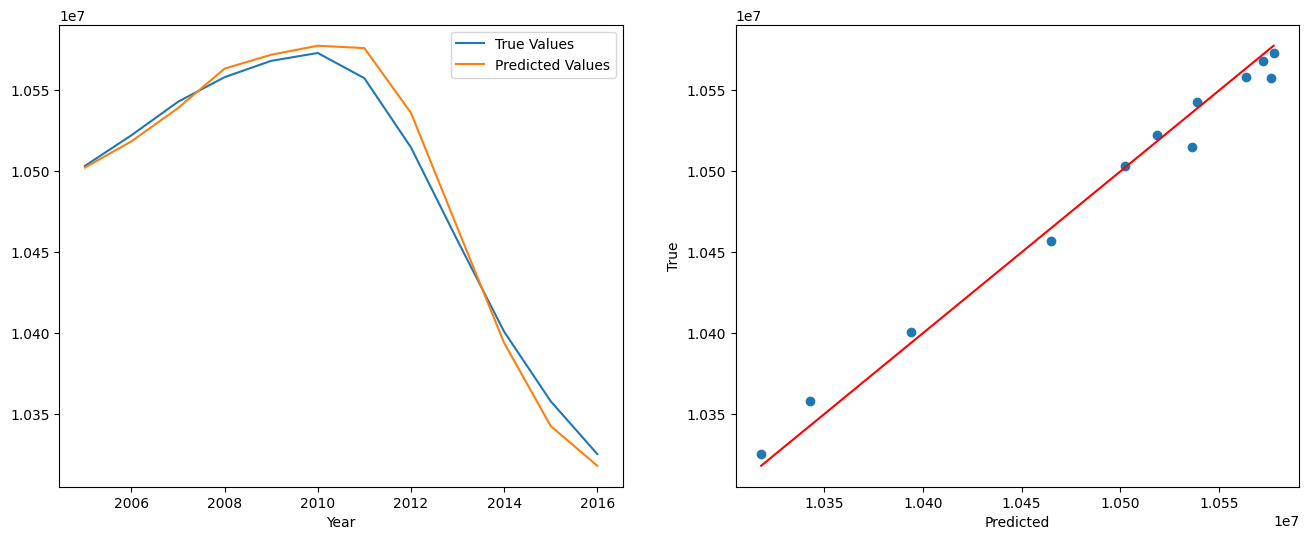

In [125]:
def plot_sub(ax, x, y, label="", xlabel="", ylabel="", title=""):
    ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()

def scat_sub(ax, x, y, label="", xlabel="", ylabel="", title=""):
    ax.scatter(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if label!="":
        ax.legend()

f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], range(min_year,max_year+1), model.get_country(label).loc[min_year:max_year], label="True Values")
plot_sub(ax[0], range(min_year,max_year+1), preds, label="Predicted Values", xlabel="Year")

scat_sub(ax[1], preds, model.get_country(label).loc[min_year:max_year], xlabel="Predicted", ylabel="True")
xy=np.linspace(preds.min(), preds.max())
ax[1].plot(xy,xy, "r")

In [130]:
y_test=pd.read_csv("data/country_population_test.csv", index_col=0).loc[2017]
y_test

Solomon Islands              636030.0
Finland                     5508214.0
Burkina Faso               19193236.0
Switzerland                 8451840.0
Timor-Leste                 1243260.0
Portugal                   10300300.0
Chile                      18470435.0
Bosnia and Herzegovina      3351534.0
Uruguay                     3436645.0
Russian Federation        144496739.0
Name: 2017, dtype: float64

In [131]:
preds = [ model.predict([2017], label)[0] for label in countries]
preds

[611356.126934526,
 5510007.707319912,
 19186006.133486174,
 8461693.22002747,
 1296229.1702576699,
 10297453.738864757,
 18056236.457141273,
 3501343.2066881293,
 3456539.744826789,
 144570720.5385588]

In [132]:
mean_squared_error( y_test, preds, squared=False)

142635.02681565477

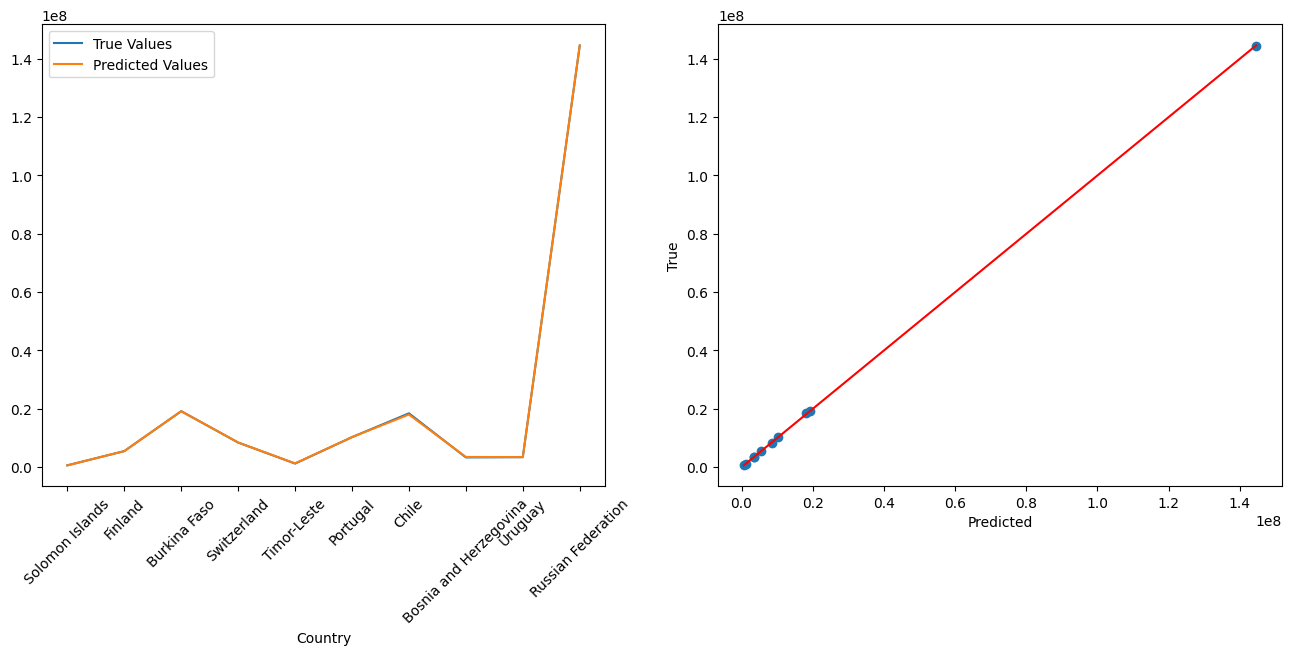

In [139]:
f, ax = plt.subplots(1,2, figsize=(16,6))
plot_sub(ax[0], x_, y_test, label="True Values")
plot_sub(ax[0], x_, preds, label="Predicted Values", xlabel="Country")
ax[0].set_xticks(x_, countries, rotation=45)

scat_sub(ax[1], preds, y_test, xlabel="Predicted", ylabel="True")
xy=np.linspace(min(preds), max(preds))
ax[1].plot(xy,xy, "r")